In [11]:
import os
import re
import numpy as np
import pandas as pd
import sklearn
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from tensorboard.plugins.hparams import api as hp

from scipy.sparse import csr_matrix
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall
from sklearn.utils import class_weight
from tensorflow.keras.layers import LSTM,Embedding,Dense,Dropout,Bidirectional,GlobalMaxPool1D,GlobalAveragePooling1D, SpatialDropout1D
import emoji


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saumyamehta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saumyamehta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
 #loading twitter slang data
slang_df = pd.read_csv('data/twitterSlang.csv')
slang_dict = dict(zip(slang_df.slang, slang_df.formal_translation))

In [13]:
def fix_slang(s):
    s_list = s.split()
    new_s_list = []
    for word in s_list:
        if word in slang_dict.keys():
            new_s_list.append(slang_dict[word])
        else:
            new_s_list.append(word)
            
    return ' '.join(new_s_list)

In [14]:
# small example of slang removal
s = "I'll fix this asap. brb"
fix_slang(s)

"I'll fix this asap. be right back"

In [15]:
def preprocess(sent, lemmatizer, stop_words):
    
    alphabet = "abcdefghijklmnopqrstuvwxyz 0123456789',."
    emojis = ''.join(c for c in sent if c in emoji.UNICODE_EMOJI['en'])
    alphabet = alphabet + emojis
    #sent = emoji_to_text(sent)
    sent = fix_slang(sent)
    sent = sent.lower()
    sent = sent.replace('@user','')
    sent = sent.replace('@[\w\-]+','')

    cleaned_sent_list = [char if char in alphabet else ' ' for char in sent] # remove all tags not in the alphabet

    cleaned_sent = ''.join(cleaned_sent_list)
    cleaned_sent_list = [lemmatizer.lemmatize(token) for token in cleaned_sent.split(" ")]
    cleaned_sent_list = [word for word in cleaned_sent_list if not word in stop_words]
    cleaned_sent = ' '.join(cleaned_sent_list)
    cleaned_sent = cleaned_sent.replace("n't",' not') # replace words like "isn't" with "is not"
    cleaned_sent = ' . '.join([x for x in cleaned_sent.split('.') if len(x)>0]) # remove multiple periods, and add spaces before and after a period
    cleaned_sent = ' , '.join([x for x in cleaned_sent.split(',') if len(x)>0]) # add spaces before and after a comma
    cleaned_sent = ' '.join(cleaned_sent.split()) # remove multiple spaces
    
    return cleaned_sent

In [16]:
olid_data = pd.read_csv("data/OLIDv1/olid-training-v1.0.tsv", sep='\t')


In [17]:
X_train = olid_data.tweet
y_train = pd.factorize(olid_data.subtask_a)[0]

X_test=pd.read_csv('data/OLIDv1/testset-levela.tsv',sep="\t").tweet
y_test=pd.read_csv( 'data/OLIDv1/labels-levela.csv',header=None).iloc[:,-1]
y_test = pd.factorize(y_test)[0]
import collections
collections.Counter(y_train)
print(f'X train shape: {X_train.shape}, y train shape: {y_train.shape}')


X train shape: (13240,), y train shape: (13240,)


Splitting data into train hold out sets.
Our split will be 80% train, 20% validation 

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.3, random_state=42)
# check shapes of train, test and validation data
print(f'X train shape: {X_train.shape}, y train shape: {y_train.shape}')
print(f'X valid shape: {X_valid.shape}, y valid shape: {y_valid.shape}')
print(f'X valid shape: {X_test.shape}, y test shape: {y_test.shape}')


X train shape: (9268,), y train shape: (9268,)
X valid shape: (3972,), y valid shape: (3972,)
X valid shape: (860,), y test shape: (860,)


Data preprocessing. 

In [19]:

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()
data_train = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_train]
data_valid = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_valid]
data_test = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_test]

In [20]:
data_train[0], data_valid[0], data_test[0]

('truly . anything avoid gun control',
 'john kerry running mouth cared ha say think single damn thing kerry ha accomplished besides run mouth . trump accomplishment exceed anything kerry could ever dream of . even becoming president',
 'whoisq wherestheserver dumpnike declasfisa democrat support antifa , muslim brotherhood , ms13 , isis , pedophilia , child trafficking , taxpayer funded abortion s , election fraud , sedition treason lockthemallup wwg1wga qanon url')

In [21]:
vocab_size = 10000
embedding_size = 300
lstm_output_dim = 32
max_length = 280
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"

Tokenisation and padding for sentences


In [22]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data_train)
word2int = tokenizer.word_index


In [23]:
train_sequences = tokenizer.texts_to_sequences(data_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

valid_sequences = tokenizer.texts_to_sequences(data_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



In [24]:
test_sequences = tokenizer.texts_to_sequences(data_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Fasttext Embeddings
References: https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html

In [25]:
def get_word_vectors(word, *arr):
    return word, np.array(arr, dtype = 'float32')

In [26]:
def build_embedddings(embedding_path, word2int):
    embeddings = dict(get_word_vectors(*x.strip().split(" ")) for x in open(embedding_path))

    nwords = min(vocab_size, len(word2int))
    embedding_matrix = np.zeros((nwords, embedding_size))

    for word, index in word2int.items():
        if index >=vocab_size:
            continue

        embedding_vec = embeddings.get(word)
        if embedding_vec is not None:
            embedding_matrix[index] = embedding_vec

    return embedding_matrix




In [27]:
fasttext_path = "embeddings/wiki-news-300d-1M.vec"

In [28]:
# fast text embeddings :
fasttext_embeddings = build_embedddings(fasttext_path, word2int)

In [29]:
print(fasttext_embeddings.shape)

(10000, 300)


# Emoji Embeddings

In [30]:
# emoji embedding
emoji_embed_path = "embeddings/emoji2vec.txt"

In [31]:
emoji_embed_index = {}
f = open(os.path.join(emoji_embed_path))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    emoji_embed_index[word] = coefs
f.close()

nwords = min(vocab_size, len(word2int))

emoji_embeddings = np.zeros((nwords, 300))
for word, i in word2int.items():
    if i >=vocab_size:
        continue
    embedding_vector = emoji_embed_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        emoji_embeddings[i] = embedding_vector

In [32]:
emoji_embeddings.shape
emoji_embeddings[20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [33]:
# combine embeddings globve and emoji

# 1. concat
concat_embed = np.hstack((fasttext_embeddings,emoji_embeddings))
# 2. sum
sum_embed = np.sum((fasttext_embeddings,emoji_embeddings),axis=0)
# 3. mean
mean_embed = np.mean((fasttext_embeddings,emoji_embeddings),axis=0)

# Building the model

RNN architecture: Embedding layer of size 100 -> lstm layer with output of 32 dimension -> linear layer activated by relu -> softmax to get probability 

In [34]:
# compute class weights : "https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html"
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights


{0: 1.510922725790675, 1: 0.7472988227705208}

In [157]:
# Training loop and early stopping 

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",mode="auto", patience = 5, restore_best_weights=True)
n_epochs = 25

In [165]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(
    vocab_size, sum_embed.shape[1], 
    embeddings_initializer=tf.keras.initializers.Constant(sum_embed),
    input_length=max_length,trainable=True))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences = True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(30, return_sequences = True)))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(20, activation="relu"))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [166]:
model_trained = model.fit(train_padded, y_train, batch_size=128, epochs = n_epochs, 
verbose=2, class_weight=class_weights,validation_data=(valid_padded, y_valid), callbacks = [callbacks])

Epoch 1/25
73/73 - 39s - loss: 0.5841 - accuracy: 0.7119 - val_loss: 0.5713 - val_accuracy: 0.7117
Epoch 2/25
73/73 - 35s - loss: 0.4210 - accuracy: 0.8174 - val_loss: 0.4976 - val_accuracy: 0.7717
Epoch 3/25
73/73 - 35s - loss: 0.3168 - accuracy: 0.8710 - val_loss: 0.6126 - val_accuracy: 0.7397
Epoch 4/25
73/73 - 35s - loss: 0.2110 - accuracy: 0.9215 - val_loss: 0.7629 - val_accuracy: 0.7054
Epoch 5/25
73/73 - 35s - loss: 0.1485 - accuracy: 0.9473 - val_loss: 0.9152 - val_accuracy: 0.7379
Epoch 6/25
73/73 - 34s - loss: 0.1080 - accuracy: 0.9630 - val_loss: 1.0664 - val_accuracy: 0.7394
Epoch 7/25
73/73 - 35s - loss: 0.0799 - accuracy: 0.9727 - val_loss: 1.1360 - val_accuracy: 0.6964


In [167]:
model_trained.history

{'loss': [0.5841438174247742,
  0.42097973823547363,
  0.3167954981327057,
  0.2109948843717575,
  0.1484682261943817,
  0.10804853588342667,
  0.07991065084934235],
 'accuracy': [0.7119119763374329,
  0.8174363374710083,
  0.8709537982940674,
  0.921450138092041,
  0.9473457336425781,
  0.962990939617157,
  0.9727017879486084],
 'val_loss': [0.5713327527046204,
  0.49755769968032837,
  0.6125962138175964,
  0.7629193663597107,
  0.915180504322052,
  1.066357970237732,
  1.136039137840271],
 'val_accuracy': [0.7117321491241455,
  0.771651566028595,
  0.7396777272224426,
  0.7054380774497986,
  0.7379153966903687,
  0.7394259572029114,
  0.6963745951652527]}

Text(0, 0.5, 'Accuracy')

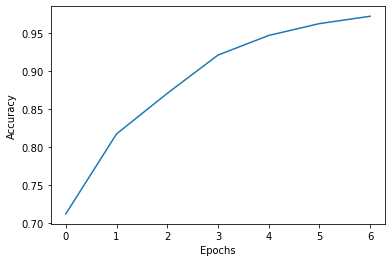

In [168]:
# PLotting accuracy of train
import matplotlib.pyplot as plt
plt.plot(model_trained.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Validation Accuracy')

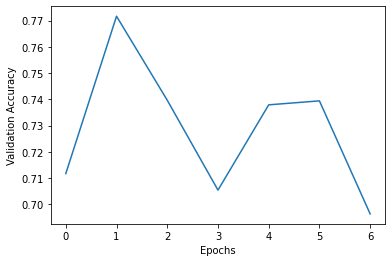

In [169]:
# PLotting accuracy of train
import matplotlib.pyplot as plt
plt.plot(model_trained.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

In [170]:

print(model.evaluate(test_padded,y_test))


27/27 [==============================] - 1s 50ms/step - loss: 0.4331 - accuracy: 0.8081
[0.4330598711967468, 0.8081395626068115]


In [171]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_padded, batch_size=128, verbose=1)
y_pred = (y_pred>0.5)
print(classification_report(y_test, y_pred))

7/7 [==============================] - 1s 110ms/step
              precision    recall  f1-score   support

           0       0.67      0.62      0.65       240
           1       0.86      0.88      0.87       620

    accuracy                           0.81       860
   macro avg       0.76      0.75      0.76       860
weighted avg       0.80      0.81      0.81       860

